In [32]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

fp = "/playpen/mufan/levi/tianlong-chen-lab/torp-v2/mrms-radar-evolution/data/2022-2024-tornado-MRMS/events/20220116_732_748_EF2/MRMS_MergedBaseReflectivity_00.50_20220116-000823_cropped_224.pkl"
with open(fp, "rb") as f:
    data = pickle.load(f)

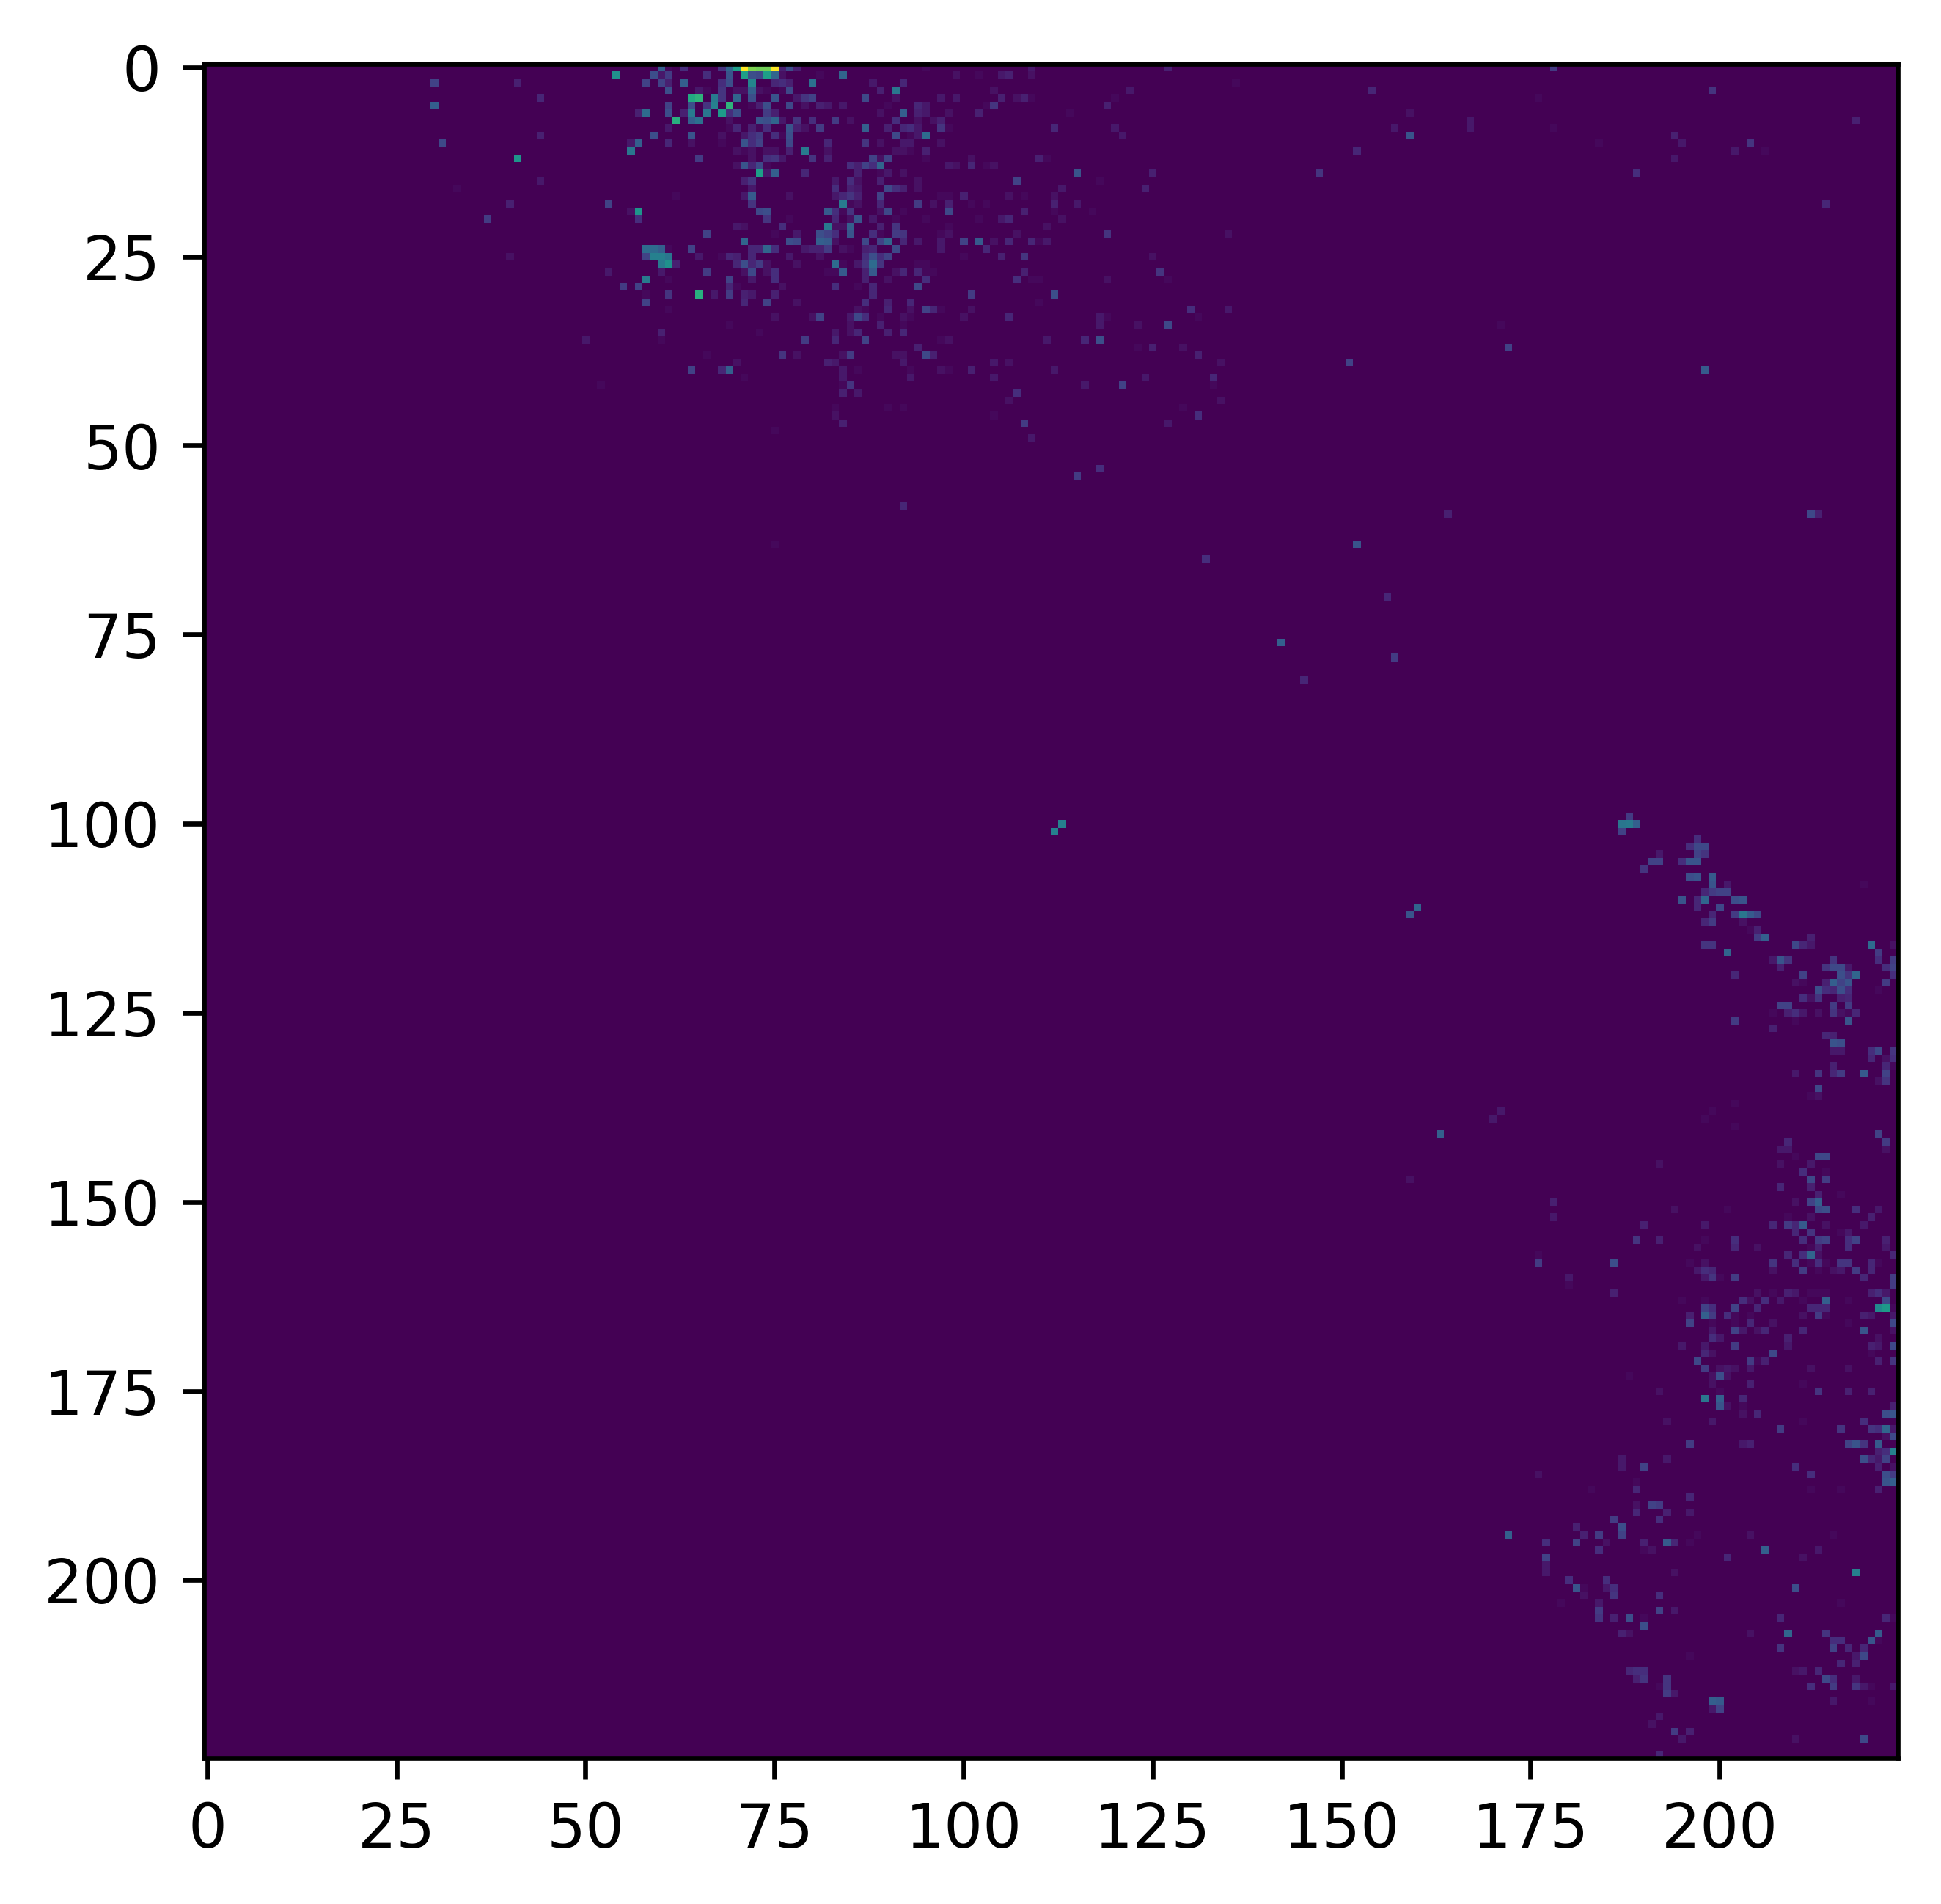

In [37]:
data_clipped = data.clip(0)
data_normed = data_clipped / data_clipped.max()

plt.figure(figsize=(10, 5), dpi=600)
plt.imshow(data_normed);

# MRMS Client Testing

In [1]:
"""
# Sources
---
- https://github.com/NOAA-National-Severe-Storms-Laboratory/mrms-support
- https://training.weather.gov/wdtd/courses/MRMS/lessons/overview-v12.2/presentation_html5.html
- https://github.com/HumphreysCarter/mrms-api

# Dataset Structure
---
- DOMAIN
    - PRODUCT
        - YYYYMMDD
            - PRODUCT_YYYYMMDD-ZZZZZZ.grib2.gz
"""

import xarray
import subprocess

from typing import List
from pathlib import Path
from s3fs import S3FileSystem


class MRMSAWSS3Client:
    """
    A high-level python API for the MRMS AWS S3 bucket.
    """

    BASE_URL_CONUS = "s3://noaa-mrms-pds/CONUS/"

    def __init__(self, format="NCEP"):

        # create an anonymous fs
        self.s3_file_system = S3FileSystem(anon=True)

    def ls(self, path: str) -> List[str]:
        self.s3_file_system.ls(path)

    def download(self, path: str, to: str, recursive=False) -> List[str]:
        """
        TODO: this function should either return:
        1. a list of raw fp strings
        2. a list of grib2gz wrapper objects
        """

        assert self.s3_file_system.exists(path), f"Error! Invalid path: {path}"
        assert Path(to).is_dir(), f"Error! 'To' not a valid dir: {to}"

        # if  : recursive is true than path msut always be a dir
        # else: path must be a file + file name must be appended to end of "to"
        remote_files = [path]
        if recursive == True:
            assert path.endswith("/"), (
                "When recursive=True the S3 path must end with '/' so it is "
                "interpreted as a prefix, not a single object."
            )
            remote_entries = self.s3_file_system.ls(path, detail=True)
            remote_files = [e["Key"] for e in remote_entries if e["type"] == "file"]
        else:
            assert not path.endswith("/"), (
                "When recursive=False the S3 path must point to a single object, "
                "not a directory prefix."
            )

        # map remote keys to download dst paths
        dst_root = Path(to).expanduser().resolve()
        local_paths: List[str] = []
        if recursive:
            prefix_len = len(path)  # strip the prefix from each key
            for key in remote_files:
                rel_key = key[prefix_len:]
                local_paths.append(str(dst_root / rel_key))
        else:
            local_paths.append(str(dst_root / Path(path).name))

        # try to download files -> "to"
        cmd = ["aws", "s3", "cp", "--no-sign-request", path, str(to)]
        if recursive:
            cmd.append("--recursive")

        result = subprocess.run(cmd, capture_output=True, text=True)
        if result.returncode != 0:
            raise RuntimeError(
                f"Download failed:\nSTDOUT: {result.stdout}\nSTDERR: {result.stderr}"
            )

        return local_paths

    def submit_bulk_download(self, paths: List[str], tos: List[str]): ...


In [ ]:
import gzip
import shutil
import xarray as xr

from pathlib import Path


class Grib2File:

    def __init__(self, path: str):
        self.path = Path(path)
        assert self.path.suffix == ".grib2"

    def to_xarray(self, engine="cfgrib") -> xr.Dataset:
        return xr.open_dataset(str(self.path), engine="cfgrib")


class ZippedGrib2File:

    def __init__(self, path: str):
        self.path = Path(path)
        assert self.path.suffix == ".gz"

    def unzip(self, to_dir: str) -> Grib2File:
        to_dir = Path(to_dir)
        assert to_dir.exists(), f"Error! Bad path: {str(to_dir)}"
        assert to_dir.is_dir(), f"Error! Invalid dir path: {str(to_dir)}"
        # TODO: make this a little more robust
        dst_fp = to_dir / Path(self.path.name.replace(".gz", ""))
        # unzip and write to out
        with gzip.open(str(self.path), "rb") as rp:
            with open(str(dst_fp), "wb") as wp:
                shutil.copyfileobj(rp, wp)
        return Grib2File(str(dst_fp))

In [3]:
client = MRMSAWSS3Client()

url = "s3://noaa-mrms-pds/CONUS/BREF_1HR_MAX_00.50/20201014/"
out_dir = "/playpen/mufan/levi/tianlong-chen-lab/torp-v2/mrms-radar-evolution/___old___/_test"
client.download(url, out_dir, recursive=True)

['/playpen/mufan/levi/tianlong-chen-lab/torp-v2/mrms-radar-evolution/___old___/_test/BREF_1HR_MAX_00.50_20201014-220000.grib2.gz',
 '/playpen/mufan/levi/tianlong-chen-lab/torp-v2/mrms-radar-evolution/___old___/_test/BREF_1HR_MAX_00.50_20201014-230000.grib2.gz']

In [16]:
fp = "/playpen/mufan/levi/tianlong-chen-lab/torp-v2/mrms-radar-evolution/___old___/_test/MRMS_BREF_1HR_MAX_00.50_20201014-220000.grib2.gz"
gf = ZippedGrib2File(fp)
g2f = gf.unzip("___old___/_test")

In [17]:
g2f.to_xarray()

/home/mufan/miniforge3/envs/torp/lib/python3.10/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


<xarray.Dataset> Size: 98MB
Dimensions:         (latitude: 3500, longitude: 7000)
Coordinates:
    time            datetime64[ns] 8B ...
    step            timedelta64[ns] 8B ...
    heightAboveSea  float64 8B ...
  * latitude        (latitude) float64 28kB 54.99 54.98 54.98 ... 20.02 20.01
  * longitude       (longitude) float64 56kB 230.0 230.0 230.0 ... 300.0 300.0
    valid_time      datetime64[ns] 8B ...
Data variables:
    unknown         (latitude, longitude) float32 98MB ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             161
    GRIB_centreDescription:  US NOAA Office of Oceanic and Atmospheric Research
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US NOAA Office of Oceanic and Atmospheric Research
    history:                 2025-05-23T16:32 GRIB to CDM+CF via cfgrib-0.9.1...

# Storm Events

In [23]:
import pandas as pd

ii_details  = "/playpen/mufan/levi/tianlong-chen-lab/torp-v2/mrms-radar-evolution/data/MRMS/StormEvents/unziped/StormEvents_details-ftp_v1.0_d2022_c20250401.csv"
iii_details = "/playpen/mufan/levi/tianlong-chen-lab/torp-v2/mrms-radar-evolution/data/MRMS/StormEvents/unziped/StormEvents_details-ftp_v1.0_d2023_c20250513.csv"
iv_details  = "/playpen/mufan/levi/tianlong-chen-lab/torp-v2/mrms-radar-evolution/data/MRMS/StormEvents/unziped/StormEvents_details-ftp_v1.0_d2024_c20250516.csv"

dfs = [pd.read_csv(fp) for fp in (ii_details, iii_details, iv_details)]
all_details = pd.concat(dfs, ignore_index=True)

In [30]:
tornado_events = all_details[all_details.TOR_LENGTH > 0]
tornado_events.to_csv("/playpen/mufan/levi/tianlong-chen-lab/torp-v2/mrms-radar-evolution/data/2024-tornado-MergedReflectivityComposite-0.5km/metadata/tornados.csv")